In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Loading the data

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Example for the data from fashion_mnist

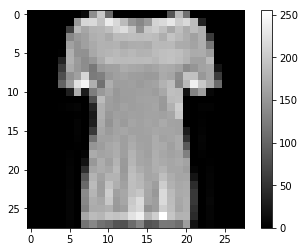

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

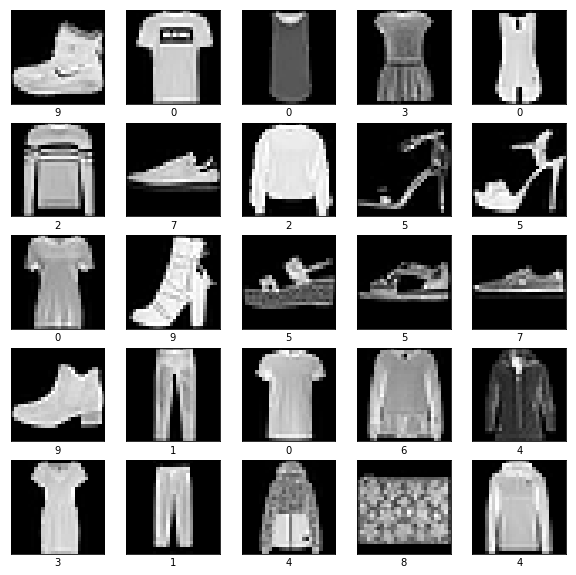

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Filter 0, 4 and 8 labels to create new data

Condition for getting only 0, 4 and 8 labels in every array

In [8]:
train_condition = ((train_labels == 0) | (train_labels == 4) | (train_labels == 8))
test_condition = ((test_labels == 0) | (test_labels == 4) | (test_labels == 8))

Filtering train and test data by the previous condition

In [9]:
train_labels_filtered = train_labels[train_condition]
train_images_filtered = train_images[train_condition]
test_labels_filtered = test_labels[test_condition]
test_images_filtered = test_images[test_condition]

In [10]:
print('Number of elements in train_labels_filtered: ', '{0:,}'.format(len(train_labels_filtered)))
print('Number of elements in train_iamges_filtered: ', '{0:,}'.format(len(train_images_filtered)))
print('Number of elements in train_labels_filtered: ', '{0:,}'.format(len(test_labels_filtered)))
print('Number of elements in train_iamges_filtered: ', '{0:,}'.format(len(test_images_filtered)))

Number of elements in train_labels_filtered:  18,000
Number of elements in train_iamges_filtered:  18,000
Number of elements in train_labels_filtered:  3,000
Number of elements in train_iamges_filtered:  3,000


Check for unique labels in new data

In [11]:
print('Labels for train data: ', np.unique(train_labels_filtered))
print('Labels for test data: ', np.unique(train_labels_filtered))

Labels for train data:  [0 4 8]
Labels for test data:  [0 4 8]


## Creating a label dictionary to match the description with each code

In [12]:
label_dict = dict()
label_dict[0] = ['T-shirt/top']
label_dict[1] = ['Trouser']
label_dict[2] = ['Pullover']
label_dict[3] = ['Dress']
label_dict[4] = ['Coat']
label_dict[5] = ['Sandal']
label_dict[6] = ['Shirt']
label_dict[7] = ['Sneaker']
label_dict[8] = ['Bag']
label_dict[9] = ['Ankle boot']

In [13]:
label_dict

{0: ['T-shirt/top'],
 1: ['Trouser'],
 2: ['Pullover'],
 3: ['Dress'],
 4: ['Coat'],
 5: ['Sandal'],
 6: ['Shirt'],
 7: ['Sneaker'],
 8: ['Bag'],
 9: ['Ankle boot']}

## Defining the function for the Logistic Regression

In [63]:
def logistic_model(epochs, lr, batch, x_model, y_model, W_model, b_model, k):
    
    tf.reset_default_graph()
    
    #Hyperparameters
    epochs = epochs #parameter of the function
    lr = lr #parameter of the function
    
    #Learnable parameters
    W = tf.Variable(W_model, name = 'W')
    b = tf.Variable(b_model, name = 'b')
    
    #Other parameters
    k = k #parameter of the function: prints every k
    batch_size = batch
    m = x_model.shape[1] #parameter of the function for the number of columns of x matrix
    
    #Model variables
    X = tf.placeholder('float64', name = 'X', shape = [batch_size, m])
    Y = tf.placeholder('float64', name = 'y', shape = [batch_size, 1])
    
    #Hypothesis
    with tf.name_scope('Hypothesis'):
        logits = tf.add(tf.matmul(X, W, name = 'Matrix_Product'), b, name = 'Logits')
        y_hat = tf.nn.softmax(logits, name = 'Hypothesis_Softmax')
    
    #Cost Function - J(m,b)
    with tf.name_scope('Cost_Function'):
        error = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_hat), reduction_indices=[1]))
    
    #Gradient Descent
    with tf.name_scope('Gradient'):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(error)
    
    #For accuracy
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Creating error summaries
    error_summary = tf.summary.scalar(name = 'Error_Summary', tensor = error)
    accuracy_summary = tf.summary.scalar(name = 'Accuracy_Summary', tensor = accuracy)
    
    graph_dir = (
        './graphs/graph_epochs='+str(epochs)+
        'lr='+str(lr)+
        'batch='+str(batch)
    )
    
    with tf.Session() as sess:
        
        tf.initialize_all_variables().run()
        print('Variables successfully initialized')
        
        writer = tf.summary.FileWriter(graph_dir, sess.graph)
        print('Directory created in', graph_dir)
        
        for epoch in range(epochs):
            
            forBatch = (epoch * batch_size) % (x_train.shape[0] - batch_size)
            print(forBatch)
            
            feed_dict = {X : x_train[forBatch:(forBatch+batch_size)], 
                         Y : y_train[forBatch:(forBatch+batch_size)]}
            
            sess.run(optimizer, feed_dict)

            if (epoch+1)%k == 0:
                #running the error
                e = sess.run(error, feed_dict)
                
                #running the summaries
                e_summary = sess.run(error_summary, feed_dict)
                a_summary = sess.run(accuracy_summary, feed_dict = {y_hat : sess.run(y_hat, feed_dict),
                                                                    Y : y_train[forBatch:(forBatch+batch_size)]})
                writer.add_summary(e_summary, epoch)
                writer.add_summary(a_summary, epoch)
                
                #print the results
                print(
                    'Epoch', epoch+1, ': \n',
                    'Bias = ', sess.run(b)
                )
                for i in range(0, m):
                    print(
                        'Variable', i+1, ' = ', sess.run(W)[i]
                    )
                print('error = ', '{:,}'.format(e))
                print('\n')
        writer.close()
    sess.close()

## Feature engineering

### Transforming x and y

In [64]:
x_train = train_images_filtered.reshape(len(train_images_filtered), 
                                        train_images_filtered.shape[1]*train_images_filtered.shape[2])
y_train = train_labels_filtered.reshape(len(train_labels_filtered), 1)
print('Dimensions for x_train data: ', x_train.shape)
print('Dimensions for x_train data: ', y_train.shape)

Dimensions for x_train data:  (18000, 784)
Dimensions for x_train data:  (18000, 1)


### Initial values for Weights and Bias

In [65]:
#To initialize weights
w_train = np.random.rand(x_train.shape[1],1)*10
print('Weights:')
for i in range(0,len(w_train)):
    print('Variable ', i+1, ' Initial Weight: ', w_train[i], sep = '')
#To initialize weights
b_train = (np.random.rand(1)*10).reshape(1,1)
print('Bias:', b_train[0])

Weights:
Variable 1 Initial Weight: [8.08015171]
Variable 2 Initial Weight: [6.54736262]
Variable 3 Initial Weight: [4.03362227]
Variable 4 Initial Weight: [6.69281607]
Variable 5 Initial Weight: [7.60927681]
Variable 6 Initial Weight: [8.70766615]
Variable 7 Initial Weight: [9.81236873]
Variable 8 Initial Weight: [2.38021977]
Variable 9 Initial Weight: [8.94526054]
Variable 10 Initial Weight: [2.81567389]
Variable 11 Initial Weight: [8.21317116]
Variable 12 Initial Weight: [7.57929657]
Variable 13 Initial Weight: [8.22166647]
Variable 14 Initial Weight: [8.53957505]
Variable 15 Initial Weight: [3.09685648]
Variable 16 Initial Weight: [5.94849862]
Variable 17 Initial Weight: [3.21992979]
Variable 18 Initial Weight: [6.71328568]
Variable 19 Initial Weight: [2.66902477]
Variable 20 Initial Weight: [3.10501175]
Variable 21 Initial Weight: [4.25668382]
Variable 22 Initial Weight: [4.95658123]
Variable 23 Initial Weight: [0.72381519]
Variable 24 Initial Weight: [3.29785592]
Variable 25 Init

Variable 563 Initial Weight: [0.84970759]
Variable 564 Initial Weight: [8.56177964]
Variable 565 Initial Weight: [8.75461521]
Variable 566 Initial Weight: [1.25010927]
Variable 567 Initial Weight: [0.37520908]
Variable 568 Initial Weight: [6.10598573]
Variable 569 Initial Weight: [9.42950683]
Variable 570 Initial Weight: [6.08382338]
Variable 571 Initial Weight: [4.31790207]
Variable 572 Initial Weight: [0.43702981]
Variable 573 Initial Weight: [9.50912978]
Variable 574 Initial Weight: [9.01870534]
Variable 575 Initial Weight: [8.96166629]
Variable 576 Initial Weight: [5.2640639]
Variable 577 Initial Weight: [1.98008788]
Variable 578 Initial Weight: [1.90290046]
Variable 579 Initial Weight: [7.43337101]
Variable 580 Initial Weight: [4.72124891]
Variable 581 Initial Weight: [6.74603459]
Variable 582 Initial Weight: [0.63618581]
Variable 583 Initial Weight: [5.65564421]
Variable 584 Initial Weight: [2.29045919]
Variable 585 Initial Weight: [0.7129668]
Variable 586 Initial Weight: [6.6498

In [68]:
logistic_model(
    epochs = 100, 
    lr = 10, 
    batch = 128, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 5
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=100lr=10batch=128
0
128
256
384
512
Epoch 5 : 
 Bias =  [[2.94801863]]
Variable 1  =  [8.08015171]
Variable 2  =  [6.54736262]
Variable 3  =  [4.03362227]
Variable 4  =  [6.69281607]
Variable 5  =  [7.60927681]
Variable 6  =  [8.70766615]
Variable 7  =  [9.81236873]
Variable 8  =  [2.38021977]
Variable 9  =  [8.94526054]
Variable 10  =  [2.81567389]
Variable 11  =  [8.21317116]
Variable 12  =  [7.57929657]
Variable 13  =  [8.22166647]
Variable 14  =  [8.53957505]
Variable 15  =  [3.09685648]
Variable 16  =  [5.94849862]
Variable 17  =  [3.21992979]
Variable 18  =  [6.71328568]
Variable 19  =  [2.66902477]
Variable 20  =  [3.10501175]
Variable 21  =  [4.25668382]
Variable 22  =  [4.95658123]
Variable 23  =  [0.72381519]
Variable 24  =  [3.29785592]
Variable 25  =  [1.24246522]
Variable 26  =  [5.06406251]
Variable 27  =  [0.62781967]
Variable 28  =  [0.67222621]
Variable 29  =  [2.9353408]
Variable 30  =  [2.3

Variable 313  =  [7.4160082]
Variable 314  =  [7.36055914]
Variable 315  =  [7.16500847]
Variable 316  =  [8.27085537]
Variable 317  =  [2.81423533]
Variable 318  =  [1.38217445]
Variable 319  =  [2.76319737]
Variable 320  =  [1.3368829]
Variable 321  =  [9.00390202]
Variable 322  =  [6.43362774]
Variable 323  =  [1.86215617]
Variable 324  =  [6.7728008]
Variable 325  =  [4.10989139]
Variable 326  =  [2.79227667]
Variable 327  =  [2.55402085]
Variable 328  =  [5.71958798]
Variable 329  =  [0.64001227]
Variable 330  =  [6.88934908]
Variable 331  =  [9.68607595]
Variable 332  =  [1.35341547]
Variable 333  =  [3.05482032]
Variable 334  =  [3.31595542]
Variable 335  =  [1.11188847]
Variable 336  =  [8.65288444]
Variable 337  =  [6.99017582]
Variable 338  =  [7.77686941]
Variable 339  =  [8.49336772]
Variable 340  =  [9.34081853]
Variable 341  =  [0.95872741]
Variable 342  =  [7.24990814]
Variable 343  =  [1.37183553]
Variable 344  =  [6.1305992]
Variable 345  =  [9.6476664]
Variable 346  =

Epoch 10 : 
 Bias =  [[2.94801863]]
Variable 1  =  [8.08015171]
Variable 2  =  [6.54736262]
Variable 3  =  [4.03362227]
Variable 4  =  [6.69281607]
Variable 5  =  [7.60927681]
Variable 6  =  [8.70766615]
Variable 7  =  [9.81236873]
Variable 8  =  [2.38021977]
Variable 9  =  [8.94526054]
Variable 10  =  [2.81567389]
Variable 11  =  [8.21317116]
Variable 12  =  [7.57929657]
Variable 13  =  [8.22166647]
Variable 14  =  [8.53957505]
Variable 15  =  [3.09685648]
Variable 16  =  [5.94849862]
Variable 17  =  [3.21992979]
Variable 18  =  [6.71328568]
Variable 19  =  [2.66902477]
Variable 20  =  [3.10501175]
Variable 21  =  [4.25668382]
Variable 22  =  [4.95658123]
Variable 23  =  [0.72381519]
Variable 24  =  [3.29785592]
Variable 25  =  [1.24246522]
Variable 26  =  [5.06406251]
Variable 27  =  [0.62781967]
Variable 28  =  [0.67222621]
Variable 29  =  [2.9353408]
Variable 30  =  [2.32219124]
Variable 31  =  [7.44706474]
Variable 32  =  [5.24152819]
Variable 33  =  [3.20095579]
Variable 34  =  [

Variable 516  =  [1.01026334]
Variable 517  =  [1.6112691]
Variable 518  =  [1.57011417]
Variable 519  =  [7.43589717]
Variable 520  =  [0.99749897]
Variable 521  =  [0.50237554]
Variable 522  =  [4.46688724]
Variable 523  =  [0.93787867]
Variable 524  =  [7.78621818]
Variable 525  =  [0.89148445]
Variable 526  =  [9.45181853]
Variable 527  =  [2.08774158]
Variable 528  =  [4.00915553]
Variable 529  =  [4.71115149]
Variable 530  =  [8.23406869]
Variable 531  =  [8.72492411]
Variable 532  =  [9.86818121]
Variable 533  =  [6.65331313]
Variable 534  =  [7.3879522]
Variable 535  =  [7.66915869]
Variable 536  =  [9.77771131]
Variable 537  =  [8.15241741]
Variable 538  =  [3.1209611]
Variable 539  =  [7.0937483]
Variable 540  =  [3.03291901]
Variable 541  =  [0.72037858]
Variable 542  =  [4.41468508]
Variable 543  =  [0.23848564]
Variable 544  =  [6.61638498]
Variable 545  =  [2.16681119]
Variable 546  =  [3.79023396]
Variable 547  =  [8.61302441]
Variable 548  =  [9.96295924]
Variable 549  

Variable 28  =  [0.67222621]
Variable 29  =  [2.9353408]
Variable 30  =  [2.32219124]
Variable 31  =  [7.44706474]
Variable 32  =  [5.24152819]
Variable 33  =  [3.20095579]
Variable 34  =  [6.67231237]
Variable 35  =  [2.0909112]
Variable 36  =  [3.92737159]
Variable 37  =  [0.31134761]
Variable 38  =  [4.78473639]
Variable 39  =  [5.9713263]
Variable 40  =  [3.69438481]
Variable 41  =  [8.828655]
Variable 42  =  [2.75189248]
Variable 43  =  [2.03517293]
Variable 44  =  [8.88922344]
Variable 45  =  [3.1417341]
Variable 46  =  [3.47993143]
Variable 47  =  [4.50942061]
Variable 48  =  [8.47016756]
Variable 49  =  [8.33359448]
Variable 50  =  [8.09615751]
Variable 51  =  [2.17570614]
Variable 52  =  [1.34518125]
Variable 53  =  [3.40431776]
Variable 54  =  [9.02988577]
Variable 55  =  [4.00983629]
Variable 56  =  [7.44475162]
Variable 57  =  [8.54396371]
Variable 58  =  [2.50234796]
Variable 59  =  [6.72216783]
Variable 60  =  [0.51562904]
Variable 61  =  [1.41454683]
Variable 62  =  [2.0

Variable 322  =  [6.43362774]
Variable 323  =  [1.86215617]
Variable 324  =  [6.7728008]
Variable 325  =  [4.10989139]
Variable 326  =  [2.79227667]
Variable 327  =  [2.55402085]
Variable 328  =  [5.71958798]
Variable 329  =  [0.64001227]
Variable 330  =  [6.88934908]
Variable 331  =  [9.68607595]
Variable 332  =  [1.35341547]
Variable 333  =  [3.05482032]
Variable 334  =  [3.31595542]
Variable 335  =  [1.11188847]
Variable 336  =  [8.65288444]
Variable 337  =  [6.99017582]
Variable 338  =  [7.77686941]
Variable 339  =  [8.49336772]
Variable 340  =  [9.34081853]
Variable 341  =  [0.95872741]
Variable 342  =  [7.24990814]
Variable 343  =  [1.37183553]
Variable 344  =  [6.1305992]
Variable 345  =  [9.6476664]
Variable 346  =  [6.89310944]
Variable 347  =  [5.33572515]
Variable 348  =  [8.94631925]
Variable 349  =  [7.43605097]
Variable 350  =  [5.25306423]
Variable 351  =  [7.61818767]
Variable 352  =  [0.68352973]
Variable 353  =  [2.52482348]
Variable 354  =  [5.69331423]
Variable 355 

Variable 99  =  [3.93193255]
Variable 100  =  [1.86580524]
Variable 101  =  [9.50456288]
Variable 102  =  [3.4189521]
Variable 103  =  [6.44646769]
Variable 104  =  [7.66565659]
Variable 105  =  [0.73539705]
Variable 106  =  [7.79999924]
Variable 107  =  [3.22032876]
Variable 108  =  [6.78415261]
Variable 109  =  [0.68870557]
Variable 110  =  [9.41691671]
Variable 111  =  [3.41472882]
Variable 112  =  [6.08965316]
Variable 113  =  [7.61677473]
Variable 114  =  [2.69632712]
Variable 115  =  [4.29453409]
Variable 116  =  [7.16360525]
Variable 117  =  [1.77098117]
Variable 118  =  [7.23889602]
Variable 119  =  [2.99277244]
Variable 120  =  [5.66980141]
Variable 121  =  [5.88982145]
Variable 122  =  [1.63496653]
Variable 123  =  [6.18350385]
Variable 124  =  [1.65675095]
Variable 125  =  [7.31568454]
Variable 126  =  [0.8974846]
Variable 127  =  [0.93775366]
Variable 128  =  [8.74455255]
Variable 129  =  [6.87721924]
Variable 130  =  [6.37221688]
Variable 131  =  [3.62702927]
Variable 132 

Variable 412  =  [4.41738174]
Variable 413  =  [6.91518294]
Variable 414  =  [4.13543352]
Variable 415  =  [7.34141718]
Variable 416  =  [2.7670404]
Variable 417  =  [4.04247474]
Variable 418  =  [9.22204323]
Variable 419  =  [3.35514821]
Variable 420  =  [7.68515397]
Variable 421  =  [8.52302798]
Variable 422  =  [5.97896429]
Variable 423  =  [4.94813805]
Variable 424  =  [3.0266909]
Variable 425  =  [1.57462873]
Variable 426  =  [7.00024527]
Variable 427  =  [3.83251648]
Variable 428  =  [2.36363583]
Variable 429  =  [7.96656771]
Variable 430  =  [8.4790396]
Variable 431  =  [9.07418807]
Variable 432  =  [7.1585592]
Variable 433  =  [7.42525521]
Variable 434  =  [6.3750826]
Variable 435  =  [5.84670321]
Variable 436  =  [2.39431607]
Variable 437  =  [7.66874939]
Variable 438  =  [7.51168578]
Variable 439  =  [4.08450111]
Variable 440  =  [7.58824151]
Variable 441  =  [6.1679649]
Variable 442  =  [7.9663543]
Variable 443  =  [7.49884889]
Variable 444  =  [0.38401808]
Variable 445  =  

Variable 752  =  [0.18795873]
Variable 753  =  [7.39044997]
Variable 754  =  [7.34616815]
Variable 755  =  [2.758501]
Variable 756  =  [9.5085203]
Variable 757  =  [7.48159051]
Variable 758  =  [8.09343521]
Variable 759  =  [8.91345596]
Variable 760  =  [2.34709098]
Variable 761  =  [1.26947885]
Variable 762  =  [4.87413612]
Variable 763  =  [5.24342987]
Variable 764  =  [9.1488499]
Variable 765  =  [3.6363516]
Variable 766  =  [7.39429837]
Variable 767  =  [7.20843925]
Variable 768  =  [1.99028052]
Variable 769  =  [9.46408845]
Variable 770  =  [9.59042845]
Variable 771  =  [2.10442032]
Variable 772  =  [0.19255563]
Variable 773  =  [7.54860049]
Variable 774  =  [7.20319469]
Variable 775  =  [9.57749637]
Variable 776  =  [1.57636435]
Variable 777  =  [5.29548833]
Variable 778  =  [7.19889976]
Variable 779  =  [0.87924988]
Variable 780  =  [7.57519252]
Variable 781  =  [9.77333725]
Variable 782  =  [5.17307323]
Variable 783  =  [4.87145905]
Variable 784  =  [4.82384958]
error =  0.0




Variable 443  =  [7.49884889]
Variable 444  =  [0.38401808]
Variable 445  =  [8.0377295]
Variable 446  =  [5.72249161]
Variable 447  =  [4.51540481]
Variable 448  =  [4.22364145]
Variable 449  =  [7.04728959]
Variable 450  =  [6.20323613]
Variable 451  =  [7.83018014]
Variable 452  =  [6.09348253]
Variable 453  =  [3.08877758]
Variable 454  =  [0.72407669]
Variable 455  =  [4.1906006]
Variable 456  =  [2.31596668]
Variable 457  =  [4.81977812]
Variable 458  =  [3.55211612]
Variable 459  =  [0.49985364]
Variable 460  =  [4.37460254]
Variable 461  =  [0.04724385]
Variable 462  =  [6.14589867]
Variable 463  =  [6.65214303]
Variable 464  =  [4.40232534]
Variable 465  =  [8.34996868]
Variable 466  =  [7.96249361]
Variable 467  =  [5.63414173]
Variable 468  =  [1.43788322]
Variable 469  =  [5.68463656]
Variable 470  =  [0.50020103]
Variable 471  =  [1.09219666]
Variable 472  =  [1.68381467]
Variable 473  =  [9.44212512]
Variable 474  =  [7.4319026]
Variable 475  =  [1.31472523]
Variable 476 

Variable 749  =  [0.63924526]
Variable 750  =  [9.63778719]
Variable 751  =  [2.70419281]
Variable 752  =  [0.18795873]
Variable 753  =  [7.39044997]
Variable 754  =  [7.34616815]
Variable 755  =  [2.758501]
Variable 756  =  [9.5085203]
Variable 757  =  [7.48159051]
Variable 758  =  [8.09343521]
Variable 759  =  [8.91345596]
Variable 760  =  [2.34709098]
Variable 761  =  [1.26947885]
Variable 762  =  [4.87413612]
Variable 763  =  [5.24342987]
Variable 764  =  [9.1488499]
Variable 765  =  [3.6363516]
Variable 766  =  [7.39429837]
Variable 767  =  [7.20843925]
Variable 768  =  [1.99028052]
Variable 769  =  [9.46408845]
Variable 770  =  [9.59042845]
Variable 771  =  [2.10442032]
Variable 772  =  [0.19255563]
Variable 773  =  [7.54860049]
Variable 774  =  [7.20319469]
Variable 775  =  [9.57749637]
Variable 776  =  [1.57636435]
Variable 777  =  [5.29548833]
Variable 778  =  [7.19889976]
Variable 779  =  [0.87924988]
Variable 780  =  [7.57519252]
Variable 781  =  [9.77333725]
Variable 782  =

Variable 462  =  [6.14589867]
Variable 463  =  [6.65214303]
Variable 464  =  [4.40232534]
Variable 465  =  [8.34996868]
Variable 466  =  [7.96249361]
Variable 467  =  [5.63414173]
Variable 468  =  [1.43788322]
Variable 469  =  [5.68463656]
Variable 470  =  [0.50020103]
Variable 471  =  [1.09219666]
Variable 472  =  [1.68381467]
Variable 473  =  [9.44212512]
Variable 474  =  [7.4319026]
Variable 475  =  [1.31472523]
Variable 476  =  [4.26006064]
Variable 477  =  [0.56298477]
Variable 478  =  [5.5105366]
Variable 479  =  [7.85017476]
Variable 480  =  [8.88477647]
Variable 481  =  [6.53713823]
Variable 482  =  [3.08630081]
Variable 483  =  [9.4684866]
Variable 484  =  [1.01710573]
Variable 485  =  [8.9871459]
Variable 486  =  [8.39978728]
Variable 487  =  [6.8234539]
Variable 488  =  [7.23785954]
Variable 489  =  [6.38816072]
Variable 490  =  [8.97459148]
Variable 491  =  [5.50687804]
Variable 492  =  [6.21726886]
Variable 493  =  [2.15449507]
Variable 494  =  [6.32892749]
Variable 495  =

Variable 766  =  [7.39429837]
Variable 767  =  [7.20843925]
Variable 768  =  [1.99028052]
Variable 769  =  [9.46408845]
Variable 770  =  [9.59042845]
Variable 771  =  [2.10442032]
Variable 772  =  [0.19255563]
Variable 773  =  [7.54860049]
Variable 774  =  [7.20319469]
Variable 775  =  [9.57749637]
Variable 776  =  [1.57636435]
Variable 777  =  [5.29548833]
Variable 778  =  [7.19889976]
Variable 779  =  [0.87924988]
Variable 780  =  [7.57519252]
Variable 781  =  [9.77333725]
Variable 782  =  [5.17307323]
Variable 783  =  [4.87145905]
Variable 784  =  [4.82384958]
error =  0.0


3840
3968
4096
4224
4352
Epoch 35 : 
 Bias =  [[2.94801863]]
Variable 1  =  [8.08015171]
Variable 2  =  [6.54736262]
Variable 3  =  [4.03362227]
Variable 4  =  [6.69281607]
Variable 5  =  [7.60927681]
Variable 6  =  [8.70766615]
Variable 7  =  [9.81236873]
Variable 8  =  [2.38021977]
Variable 9  =  [8.94526054]
Variable 10  =  [2.81567389]
Variable 11  =  [8.21317116]
Variable 12  =  [7.57929657]
Variable 13  = 

Variable 549  =  [1.28745007]
Variable 550  =  [3.77727919]
Variable 551  =  [0.91401814]
Variable 552  =  [5.14234999]
Variable 553  =  [2.17825089]
Variable 554  =  [3.80427964]
Variable 555  =  [3.45001115]
Variable 556  =  [3.44926459]
Variable 557  =  [7.79148126]
Variable 558  =  [7.32782626]
Variable 559  =  [7.38630567]
Variable 560  =  [8.283473]
Variable 561  =  [9.78155308]
Variable 562  =  [7.55499868]
Variable 563  =  [0.84970759]
Variable 564  =  [8.56177964]
Variable 565  =  [8.75461521]
Variable 566  =  [1.25010927]
Variable 567  =  [0.37520908]
Variable 568  =  [6.10598573]
Variable 569  =  [9.42950683]
Variable 570  =  [6.08382338]
Variable 571  =  [4.31790207]
Variable 572  =  [0.43702981]
Variable 573  =  [9.50912978]
Variable 574  =  [9.01870534]
Variable 575  =  [8.96166629]
Variable 576  =  [5.2640639]
Variable 577  =  [1.98008788]
Variable 578  =  [1.90290046]
Variable 579  =  [7.43337101]
Variable 580  =  [4.72124891]
Variable 581  =  [6.74603459]
Variable 582 

Variable 346  =  [6.89310944]
Variable 347  =  [5.33572515]
Variable 348  =  [8.94631925]
Variable 349  =  [7.43605097]
Variable 350  =  [5.25306423]
Variable 351  =  [7.61818767]
Variable 352  =  [0.68352973]
Variable 353  =  [2.52482348]
Variable 354  =  [5.69331423]
Variable 355  =  [3.22131359]
Variable 356  =  [2.23294887]
Variable 357  =  [3.26778245]
Variable 358  =  [0.05530605]
Variable 359  =  [6.83890338]
Variable 360  =  [4.74477441]
Variable 361  =  [8.72670555]
Variable 362  =  [2.9982067]
Variable 363  =  [3.38769793]
Variable 364  =  [6.23934581]
Variable 365  =  [2.70887413]
Variable 366  =  [9.97238497]
Variable 367  =  [1.52409884]
Variable 368  =  [0.15572078]
Variable 369  =  [4.78857464]
Variable 370  =  [0.0812385]
Variable 371  =  [7.66461252]
Variable 372  =  [6.65871562]
Variable 373  =  [3.99689512]
Variable 374  =  [2.15830866]
Variable 375  =  [7.30679209]
Variable 376  =  [5.66900838]
Variable 377  =  [2.5783339]
Variable 378  =  [7.84033478]
Variable 379 

Variable 636  =  [7.86779963]
Variable 637  =  [9.41734664]
Variable 638  =  [6.07231894]
Variable 639  =  [0.3630866]
Variable 640  =  [2.41556186]
Variable 641  =  [1.7094235]
Variable 642  =  [3.27658661]
Variable 643  =  [1.95576737]
Variable 644  =  [1.37827493]
Variable 645  =  [5.28706902]
Variable 646  =  [8.62206159]
Variable 647  =  [0.2573743]
Variable 648  =  [3.55767175]
Variable 649  =  [9.65786906]
Variable 650  =  [9.55980488]
Variable 651  =  [2.66674857]
Variable 652  =  [1.25441881]
Variable 653  =  [4.18828466]
Variable 654  =  [4.4337165]
Variable 655  =  [7.70963462]
Variable 656  =  [5.28835522]
Variable 657  =  [8.68873642]
Variable 658  =  [9.8804059]
Variable 659  =  [1.69440561]
Variable 660  =  [3.10482691]
Variable 661  =  [0.08542948]
Variable 662  =  [0.50086162]
Variable 663  =  [4.95782509]
Variable 664  =  [7.5070786]
Variable 665  =  [0.26547537]
Variable 666  =  [1.06518129]
Variable 667  =  [7.70988657]
Variable 668  =  [7.33069297]
Variable 669  = 

Variable 171  =  [3.77155461]
Variable 172  =  [9.36215986]
Variable 173  =  [6.38158043]
Variable 174  =  [4.89237378]
Variable 175  =  [1.49724676]
Variable 176  =  [7.89403131]
Variable 177  =  [9.98037243]
Variable 178  =  [1.46931178]
Variable 179  =  [3.79433924]
Variable 180  =  [7.01339047]
Variable 181  =  [3.01544839]
Variable 182  =  [8.98965349]
Variable 183  =  [6.02243865]
Variable 184  =  [7.28528104]
Variable 185  =  [6.12491043]
Variable 186  =  [9.52572956]
Variable 187  =  [7.92975731]
Variable 188  =  [3.15581212]
Variable 189  =  [5.42735553]
Variable 190  =  [6.73385287]
Variable 191  =  [9.49237137]
Variable 192  =  [6.36532115]
Variable 193  =  [4.08464376]
Variable 194  =  [3.98692307]
Variable 195  =  [4.17967927]
Variable 196  =  [5.81394672]
Variable 197  =  [4.86928479]
Variable 198  =  [3.55312307]
Variable 199  =  [8.31696436]
Variable 200  =  [8.90353914]
Variable 201  =  [5.43314069]
Variable 202  =  [1.45561911]
Variable 203  =  [4.16574718]
Variable 2

Variable 474  =  [7.4319026]
Variable 475  =  [1.31472523]
Variable 476  =  [4.26006064]
Variable 477  =  [0.56298477]
Variable 478  =  [5.5105366]
Variable 479  =  [7.85017476]
Variable 480  =  [8.88477647]
Variable 481  =  [6.53713823]
Variable 482  =  [3.08630081]
Variable 483  =  [9.4684866]
Variable 484  =  [1.01710573]
Variable 485  =  [8.9871459]
Variable 486  =  [8.39978728]
Variable 487  =  [6.8234539]
Variable 488  =  [7.23785954]
Variable 489  =  [6.38816072]
Variable 490  =  [8.97459148]
Variable 491  =  [5.50687804]
Variable 492  =  [6.21726886]
Variable 493  =  [2.15449507]
Variable 494  =  [6.32892749]
Variable 495  =  [9.87408349]
Variable 496  =  [4.94966344]
Variable 497  =  [7.28699095]
Variable 498  =  [5.91520488]
Variable 499  =  [1.72422949]
Variable 500  =  [1.52574778]
Variable 501  =  [7.50939605]
Variable 502  =  [5.63243265]
Variable 503  =  [0.26152627]
Variable 504  =  [0.24174746]
Variable 505  =  [3.21435986]
Variable 506  =  [8.05510723]
Variable 507  =

Variable 17  =  [3.21992979]
Variable 18  =  [6.71328568]
Variable 19  =  [2.66902477]
Variable 20  =  [3.10501175]
Variable 21  =  [4.25668382]
Variable 22  =  [4.95658123]
Variable 23  =  [0.72381519]
Variable 24  =  [3.29785592]
Variable 25  =  [1.24246522]
Variable 26  =  [5.06406251]
Variable 27  =  [0.62781967]
Variable 28  =  [0.67222621]
Variable 29  =  [2.9353408]
Variable 30  =  [2.32219124]
Variable 31  =  [7.44706474]
Variable 32  =  [5.24152819]
Variable 33  =  [3.20095579]
Variable 34  =  [6.67231237]
Variable 35  =  [2.0909112]
Variable 36  =  [3.92737159]
Variable 37  =  [0.31134761]
Variable 38  =  [4.78473639]
Variable 39  =  [5.9713263]
Variable 40  =  [3.69438481]
Variable 41  =  [8.828655]
Variable 42  =  [2.75189248]
Variable 43  =  [2.03517293]
Variable 44  =  [8.88922344]
Variable 45  =  [3.1417341]
Variable 46  =  [3.47993143]
Variable 47  =  [4.50942061]
Variable 48  =  [8.47016756]
Variable 49  =  [8.33359448]
Variable 50  =  [8.09615751]
Variable 51  =  [2.1

Variable 311  =  [4.41976527]
Variable 312  =  [1.00101741]
Variable 313  =  [7.4160082]
Variable 314  =  [7.36055914]
Variable 315  =  [7.16500847]
Variable 316  =  [8.27085537]
Variable 317  =  [2.81423533]
Variable 318  =  [1.38217445]
Variable 319  =  [2.76319737]
Variable 320  =  [1.3368829]
Variable 321  =  [9.00390202]
Variable 322  =  [6.43362774]
Variable 323  =  [1.86215617]
Variable 324  =  [6.7728008]
Variable 325  =  [4.10989139]
Variable 326  =  [2.79227667]
Variable 327  =  [2.55402085]
Variable 328  =  [5.71958798]
Variable 329  =  [0.64001227]
Variable 330  =  [6.88934908]
Variable 331  =  [9.68607595]
Variable 332  =  [1.35341547]
Variable 333  =  [3.05482032]
Variable 334  =  [3.31595542]
Variable 335  =  [1.11188847]
Variable 336  =  [8.65288444]
Variable 337  =  [6.99017582]
Variable 338  =  [7.77686941]
Variable 339  =  [8.49336772]
Variable 340  =  [9.34081853]
Variable 341  =  [0.95872741]
Variable 342  =  [7.24990814]
Variable 343  =  [1.37183553]
Variable 344 

Variable 645  =  [5.28706902]
Variable 646  =  [8.62206159]
Variable 647  =  [0.2573743]
Variable 648  =  [3.55767175]
Variable 649  =  [9.65786906]
Variable 650  =  [9.55980488]
Variable 651  =  [2.66674857]
Variable 652  =  [1.25441881]
Variable 653  =  [4.18828466]
Variable 654  =  [4.4337165]
Variable 655  =  [7.70963462]
Variable 656  =  [5.28835522]
Variable 657  =  [8.68873642]
Variable 658  =  [9.8804059]
Variable 659  =  [1.69440561]
Variable 660  =  [3.10482691]
Variable 661  =  [0.08542948]
Variable 662  =  [0.50086162]
Variable 663  =  [4.95782509]
Variable 664  =  [7.5070786]
Variable 665  =  [0.26547537]
Variable 666  =  [1.06518129]
Variable 667  =  [7.70988657]
Variable 668  =  [7.33069297]
Variable 669  =  [8.53009376]
Variable 670  =  [3.31828481]
Variable 671  =  [0.80709907]
Variable 672  =  [0.48576048]
Variable 673  =  [0.02836637]
Variable 674  =  [9.59604532]
Variable 675  =  [6.79120424]
Variable 676  =  [6.51446462]
Variable 677  =  [8.67566237]
Variable 678  

Variable 149  =  [8.80738875]
Variable 150  =  [9.2376986]
Variable 151  =  [7.20311497]
Variable 152  =  [4.55409194]
Variable 153  =  [9.52239828]
Variable 154  =  [5.32924519]
Variable 155  =  [4.05701366]
Variable 156  =  [2.59721992]
Variable 157  =  [0.49637235]
Variable 158  =  [0.93234658]
Variable 159  =  [8.35578696]
Variable 160  =  [7.41382121]
Variable 161  =  [7.11226956]
Variable 162  =  [8.53284682]
Variable 163  =  [8.82950101]
Variable 164  =  [8.72085203]
Variable 165  =  [6.93835145]
Variable 166  =  [4.55294527]
Variable 167  =  [9.74248996]
Variable 168  =  [6.22237288]
Variable 169  =  [0.85047487]
Variable 170  =  [8.16284246]
Variable 171  =  [3.77155461]
Variable 172  =  [9.36215986]
Variable 173  =  [6.38158043]
Variable 174  =  [4.89237378]
Variable 175  =  [1.49724676]
Variable 176  =  [7.89403131]
Variable 177  =  [9.98037243]
Variable 178  =  [1.46931178]
Variable 179  =  [3.79433924]
Variable 180  =  [7.01339047]
Variable 181  =  [3.01544839]
Variable 18

Variable 499  =  [1.72422949]
Variable 500  =  [1.52574778]
Variable 501  =  [7.50939605]
Variable 502  =  [5.63243265]
Variable 503  =  [0.26152627]
Variable 504  =  [0.24174746]
Variable 505  =  [3.21435986]
Variable 506  =  [8.05510723]
Variable 507  =  [9.35205798]
Variable 508  =  [4.86188119]
Variable 509  =  [4.25175271]
Variable 510  =  [5.48114222]
Variable 511  =  [6.32970632]
Variable 512  =  [9.97274112]
Variable 513  =  [8.45963317]
Variable 514  =  [4.83416297]
Variable 515  =  [9.13404435]
Variable 516  =  [1.01026334]
Variable 517  =  [1.6112691]
Variable 518  =  [1.57011417]
Variable 519  =  [7.43589717]
Variable 520  =  [0.99749897]
Variable 521  =  [0.50237554]
Variable 522  =  [4.46688724]
Variable 523  =  [0.93787867]
Variable 524  =  [7.78621818]
Variable 525  =  [0.89148445]
Variable 526  =  [9.45181853]
Variable 527  =  [2.08774158]
Variable 528  =  [4.00915553]
Variable 529  =  [4.71115149]
Variable 530  =  [8.23406869]
Variable 531  =  [8.72492411]
Variable 53

Variable 774  =  [7.20319469]
Variable 775  =  [9.57749637]
Variable 776  =  [1.57636435]
Variable 777  =  [5.29548833]
Variable 778  =  [7.19889976]
Variable 779  =  [0.87924988]
Variable 780  =  [7.57519252]
Variable 781  =  [9.77333725]
Variable 782  =  [5.17307323]
Variable 783  =  [4.87145905]
Variable 784  =  [4.82384958]
error =  0.0


7040
7168
7296
7424
7552
Epoch 60 : 
 Bias =  [[2.94801863]]
Variable 1  =  [8.08015171]
Variable 2  =  [6.54736262]
Variable 3  =  [4.03362227]
Variable 4  =  [6.69281607]
Variable 5  =  [7.60927681]
Variable 6  =  [8.70766615]
Variable 7  =  [9.81236873]
Variable 8  =  [2.38021977]
Variable 9  =  [8.94526054]
Variable 10  =  [2.81567389]
Variable 11  =  [8.21317116]
Variable 12  =  [7.57929657]
Variable 13  =  [8.22166647]
Variable 14  =  [8.53957505]
Variable 15  =  [3.09685648]
Variable 16  =  [5.94849862]
Variable 17  =  [3.21992979]
Variable 18  =  [6.71328568]
Variable 19  =  [2.66902477]
Variable 20  =  [3.10501175]
Variable 21  =  [4.2566

Variable 460  =  [4.37460254]
Variable 461  =  [0.04724385]
Variable 462  =  [6.14589867]
Variable 463  =  [6.65214303]
Variable 464  =  [4.40232534]
Variable 465  =  [8.34996868]
Variable 466  =  [7.96249361]
Variable 467  =  [5.63414173]
Variable 468  =  [1.43788322]
Variable 469  =  [5.68463656]
Variable 470  =  [0.50020103]
Variable 471  =  [1.09219666]
Variable 472  =  [1.68381467]
Variable 473  =  [9.44212512]
Variable 474  =  [7.4319026]
Variable 475  =  [1.31472523]
Variable 476  =  [4.26006064]
Variable 477  =  [0.56298477]
Variable 478  =  [5.5105366]
Variable 479  =  [7.85017476]
Variable 480  =  [8.88477647]
Variable 481  =  [6.53713823]
Variable 482  =  [3.08630081]
Variable 483  =  [9.4684866]
Variable 484  =  [1.01710573]
Variable 485  =  [8.9871459]
Variable 486  =  [8.39978728]
Variable 487  =  [6.8234539]
Variable 488  =  [7.23785954]
Variable 489  =  [6.38816072]
Variable 490  =  [8.97459148]
Variable 491  =  [5.50687804]
Variable 492  =  [6.21726886]
Variable 493  =

Variable 753  =  [7.39044997]
Variable 754  =  [7.34616815]
Variable 755  =  [2.758501]
Variable 756  =  [9.5085203]
Variable 757  =  [7.48159051]
Variable 758  =  [8.09343521]
Variable 759  =  [8.91345596]
Variable 760  =  [2.34709098]
Variable 761  =  [1.26947885]
Variable 762  =  [4.87413612]
Variable 763  =  [5.24342987]
Variable 764  =  [9.1488499]
Variable 765  =  [3.6363516]
Variable 766  =  [7.39429837]
Variable 767  =  [7.20843925]
Variable 768  =  [1.99028052]
Variable 769  =  [9.46408845]
Variable 770  =  [9.59042845]
Variable 771  =  [2.10442032]
Variable 772  =  [0.19255563]
Variable 773  =  [7.54860049]
Variable 774  =  [7.20319469]
Variable 775  =  [9.57749637]
Variable 776  =  [1.57636435]
Variable 777  =  [5.29548833]
Variable 778  =  [7.19889976]
Variable 779  =  [0.87924988]
Variable 780  =  [7.57519252]
Variable 781  =  [9.77333725]
Variable 782  =  [5.17307323]
Variable 783  =  [4.87145905]
Variable 784  =  [4.82384958]
error =  0.0


7680
7808
7936
8064
8192
Epoch

Variable 247  =  [1.23167623]
Variable 248  =  [8.11924892]
Variable 249  =  [0.67566708]
Variable 250  =  [2.38848309]
Variable 251  =  [1.45238453]
Variable 252  =  [5.59753776]
Variable 253  =  [6.18956672]
Variable 254  =  [5.45083634]
Variable 255  =  [8.03692832]
Variable 256  =  [8.31096738]
Variable 257  =  [7.87191601]
Variable 258  =  [5.13053382]
Variable 259  =  [9.65905045]
Variable 260  =  [9.1836746]
Variable 261  =  [8.12623431]
Variable 262  =  [8.65642966]
Variable 263  =  [9.69371074]
Variable 264  =  [4.10751711]
Variable 265  =  [1.18550518]
Variable 266  =  [7.98359685]
Variable 267  =  [2.9291212]
Variable 268  =  [9.85325857]
Variable 269  =  [8.53116341]
Variable 270  =  [0.14004845]
Variable 271  =  [2.15260764]
Variable 272  =  [0.5000116]
Variable 273  =  [9.22594668]
Variable 274  =  [7.98342427]
Variable 275  =  [3.99776588]
Variable 276  =  [8.93391992]
Variable 277  =  [8.09200409]
Variable 278  =  [0.12610525]
Variable 279  =  [0.80906699]
Variable 280 

Variable 574  =  [9.01870534]
Variable 575  =  [8.96166629]
Variable 576  =  [5.2640639]
Variable 577  =  [1.98008788]
Variable 578  =  [1.90290046]
Variable 579  =  [7.43337101]
Variable 580  =  [4.72124891]
Variable 581  =  [6.74603459]
Variable 582  =  [0.63618581]
Variable 583  =  [5.65564421]
Variable 584  =  [2.29045919]
Variable 585  =  [0.7129668]
Variable 586  =  [6.64984166]
Variable 587  =  [5.30189935]
Variable 588  =  [7.77798868]
Variable 589  =  [9.3650285]
Variable 590  =  [3.62791441]
Variable 591  =  [1.89333479]
Variable 592  =  [8.13490138]
Variable 593  =  [9.96188573]
Variable 594  =  [7.43375675]
Variable 595  =  [9.05385066]
Variable 596  =  [0.53678979]
Variable 597  =  [4.15138117]
Variable 598  =  [3.45307182]
Variable 599  =  [6.39754678]
Variable 600  =  [0.62300858]
Variable 601  =  [8.57283675]
Variable 602  =  [7.98478727]
Variable 603  =  [6.96670611]
Variable 604  =  [8.70352848]
Variable 605  =  [3.62550863]
Variable 606  =  [1.61111488]
Variable 607 

Variable 126  =  [0.8974846]
Variable 127  =  [0.93775366]
Variable 128  =  [8.74455255]
Variable 129  =  [6.87721924]
Variable 130  =  [6.37221688]
Variable 131  =  [3.62702927]
Variable 132  =  [9.44193152]
Variable 133  =  [2.98262162]
Variable 134  =  [9.55665319]
Variable 135  =  [0.62734216]
Variable 136  =  [1.44173193]
Variable 137  =  [8.19930745]
Variable 138  =  [5.45803968]
Variable 139  =  [0.97189289]
Variable 140  =  [2.65373525]
Variable 141  =  [6.89732682]
Variable 142  =  [2.39135626]
Variable 143  =  [5.34928028]
Variable 144  =  [2.80871293]
Variable 145  =  [6.17814435]
Variable 146  =  [0.07347646]
Variable 147  =  [4.79508625]
Variable 148  =  [7.56059975]
Variable 149  =  [8.80738875]
Variable 150  =  [9.2376986]
Variable 151  =  [7.20311497]
Variable 152  =  [4.55409194]
Variable 153  =  [9.52239828]
Variable 154  =  [5.32924519]
Variable 155  =  [4.05701366]
Variable 156  =  [2.59721992]
Variable 157  =  [0.49637235]
Variable 158  =  [0.93234658]
Variable 159

Variable 411  =  [7.3972137]
Variable 412  =  [4.41738174]
Variable 413  =  [6.91518294]
Variable 414  =  [4.13543352]
Variable 415  =  [7.34141718]
Variable 416  =  [2.7670404]
Variable 417  =  [4.04247474]
Variable 418  =  [9.22204323]
Variable 419  =  [3.35514821]
Variable 420  =  [7.68515397]
Variable 421  =  [8.52302798]
Variable 422  =  [5.97896429]
Variable 423  =  [4.94813805]
Variable 424  =  [3.0266909]
Variable 425  =  [1.57462873]
Variable 426  =  [7.00024527]
Variable 427  =  [3.83251648]
Variable 428  =  [2.36363583]
Variable 429  =  [7.96656771]
Variable 430  =  [8.4790396]
Variable 431  =  [9.07418807]
Variable 432  =  [7.1585592]
Variable 433  =  [7.42525521]
Variable 434  =  [6.3750826]
Variable 435  =  [5.84670321]
Variable 436  =  [2.39431607]
Variable 437  =  [7.66874939]
Variable 438  =  [7.51168578]
Variable 439  =  [4.08450111]
Variable 440  =  [7.58824151]
Variable 441  =  [6.1679649]
Variable 442  =  [7.9663543]
Variable 443  =  [7.49884889]
Variable 444  =  [

Variable 758  =  [8.09343521]
Variable 759  =  [8.91345596]
Variable 760  =  [2.34709098]
Variable 761  =  [1.26947885]
Variable 762  =  [4.87413612]
Variable 763  =  [5.24342987]
Variable 764  =  [9.1488499]
Variable 765  =  [3.6363516]
Variable 766  =  [7.39429837]
Variable 767  =  [7.20843925]
Variable 768  =  [1.99028052]
Variable 769  =  [9.46408845]
Variable 770  =  [9.59042845]
Variable 771  =  [2.10442032]
Variable 772  =  [0.19255563]
Variable 773  =  [7.54860049]
Variable 774  =  [7.20319469]
Variable 775  =  [9.57749637]
Variable 776  =  [1.57636435]
Variable 777  =  [5.29548833]
Variable 778  =  [7.19889976]
Variable 779  =  [0.87924988]
Variable 780  =  [7.57519252]
Variable 781  =  [9.77333725]
Variable 782  =  [5.17307323]
Variable 783  =  [4.87145905]
Variable 784  =  [4.82384958]
error =  0.0


8960
9088
9216
9344
9472
Epoch 75 : 
 Bias =  [[2.94801863]]
Variable 1  =  [8.08015171]
Variable 2  =  [6.54736262]
Variable 3  =  [4.03362227]
Variable 4  =  [6.69281607]
Vari

Variable 249  =  [0.67566708]
Variable 250  =  [2.38848309]
Variable 251  =  [1.45238453]
Variable 252  =  [5.59753776]
Variable 253  =  [6.18956672]
Variable 254  =  [5.45083634]
Variable 255  =  [8.03692832]
Variable 256  =  [8.31096738]
Variable 257  =  [7.87191601]
Variable 258  =  [5.13053382]
Variable 259  =  [9.65905045]
Variable 260  =  [9.1836746]
Variable 261  =  [8.12623431]
Variable 262  =  [8.65642966]
Variable 263  =  [9.69371074]
Variable 264  =  [4.10751711]
Variable 265  =  [1.18550518]
Variable 266  =  [7.98359685]
Variable 267  =  [2.9291212]
Variable 268  =  [9.85325857]
Variable 269  =  [8.53116341]
Variable 270  =  [0.14004845]
Variable 271  =  [2.15260764]
Variable 272  =  [0.5000116]
Variable 273  =  [9.22594668]
Variable 274  =  [7.98342427]
Variable 275  =  [3.99776588]
Variable 276  =  [8.93391992]
Variable 277  =  [8.09200409]
Variable 278  =  [0.12610525]
Variable 279  =  [0.80906699]
Variable 280  =  [9.50326764]
Variable 281  =  [0.11148404]
Variable 282 

Variable 613  =  [8.18802205]
Variable 614  =  [8.04942421]
Variable 615  =  [1.76062344]
Variable 616  =  [0.03235372]
Variable 617  =  [1.85158276]
Variable 618  =  [6.04404601]
Variable 619  =  [3.42407258]
Variable 620  =  [1.82025893]
Variable 621  =  [8.26243872]
Variable 622  =  [3.56272511]
Variable 623  =  [6.85582556]
Variable 624  =  [0.08441764]
Variable 625  =  [0.63424716]
Variable 626  =  [9.44679903]
Variable 627  =  [2.62873018]
Variable 628  =  [6.93473747]
Variable 629  =  [9.47192419]
Variable 630  =  [5.24604586]
Variable 631  =  [7.30653648]
Variable 632  =  [0.4143295]
Variable 633  =  [0.97595707]
Variable 634  =  [4.21459951]
Variable 635  =  [0.85510365]
Variable 636  =  [7.86779963]
Variable 637  =  [9.41734664]
Variable 638  =  [6.07231894]
Variable 639  =  [0.3630866]
Variable 640  =  [2.41556186]
Variable 641  =  [1.7094235]
Variable 642  =  [3.27658661]
Variable 643  =  [1.95576737]
Variable 644  =  [1.37827493]
Variable 645  =  [5.28706902]
Variable 646 

Variable 414  =  [4.13543352]
Variable 415  =  [7.34141718]
Variable 416  =  [2.7670404]
Variable 417  =  [4.04247474]
Variable 418  =  [9.22204323]
Variable 419  =  [3.35514821]
Variable 420  =  [7.68515397]
Variable 421  =  [8.52302798]
Variable 422  =  [5.97896429]
Variable 423  =  [4.94813805]
Variable 424  =  [3.0266909]
Variable 425  =  [1.57462873]
Variable 426  =  [7.00024527]
Variable 427  =  [3.83251648]
Variable 428  =  [2.36363583]
Variable 429  =  [7.96656771]
Variable 430  =  [8.4790396]
Variable 431  =  [9.07418807]
Variable 432  =  [7.1585592]
Variable 433  =  [7.42525521]
Variable 434  =  [6.3750826]
Variable 435  =  [5.84670321]
Variable 436  =  [2.39431607]
Variable 437  =  [7.66874939]
Variable 438  =  [7.51168578]
Variable 439  =  [4.08450111]
Variable 440  =  [7.58824151]
Variable 441  =  [6.1679649]
Variable 442  =  [7.9663543]
Variable 443  =  [7.49884889]
Variable 444  =  [0.38401808]
Variable 445  =  [8.0377295]
Variable 446  =  [5.72249161]
Variable 447  =  [

Variable 711  =  [9.74102416]
Variable 712  =  [5.42261735]
Variable 713  =  [0.00597106]
Variable 714  =  [5.57844419]
Variable 715  =  [2.01898133]
Variable 716  =  [7.76138173]
Variable 717  =  [3.37550872]
Variable 718  =  [1.47844448]
Variable 719  =  [0.37651949]
Variable 720  =  [7.68113261]
Variable 721  =  [4.62810629]
Variable 722  =  [3.9231334]
Variable 723  =  [9.86993041]
Variable 724  =  [0.15727626]
Variable 725  =  [0.53074543]
Variable 726  =  [4.83314954]
Variable 727  =  [7.98656217]
Variable 728  =  [5.66262514]
Variable 729  =  [7.77599212]
Variable 730  =  [4.38306743]
Variable 731  =  [4.09133703]
Variable 732  =  [9.67326305]
Variable 733  =  [9.50562573]
Variable 734  =  [8.92374011]
Variable 735  =  [7.22499269]
Variable 736  =  [2.5359403]
Variable 737  =  [0.30810168]
Variable 738  =  [2.04995864]
Variable 739  =  [4.09102921]
Variable 740  =  [1.14951448]
Variable 741  =  [9.41644836]
Variable 742  =  [7.95663766]
Variable 743  =  [1.79170983]
Variable 744

Variable 218  =  [2.03123776]
Variable 219  =  [7.77795333]
Variable 220  =  [8.14131216]
Variable 221  =  [6.36036292]
Variable 222  =  [1.3485886]
Variable 223  =  [3.71599836]
Variable 224  =  [7.79959408]
Variable 225  =  [8.00666494]
Variable 226  =  [7.63635947]
Variable 227  =  [0.90632627]
Variable 228  =  [5.66408926]
Variable 229  =  [0.88464629]
Variable 230  =  [6.13503718]
Variable 231  =  [5.70418643]
Variable 232  =  [2.89066411]
Variable 233  =  [1.07262097]
Variable 234  =  [2.66379241]
Variable 235  =  [5.5195627]
Variable 236  =  [3.93071111]
Variable 237  =  [4.67108884]
Variable 238  =  [7.74639717]
Variable 239  =  [5.1998989]
Variable 240  =  [3.17572631]
Variable 241  =  [6.08595362]
Variable 242  =  [0.74183665]
Variable 243  =  [3.83490707]
Variable 244  =  [3.38244098]
Variable 245  =  [5.76297825]
Variable 246  =  [7.58240074]
Variable 247  =  [1.23167623]
Variable 248  =  [8.11924892]
Variable 249  =  [0.67566708]
Variable 250  =  [2.38848309]
Variable 251 

Variable 548  =  [9.96295924]
Variable 549  =  [1.28745007]
Variable 550  =  [3.77727919]
Variable 551  =  [0.91401814]
Variable 552  =  [5.14234999]
Variable 553  =  [2.17825089]
Variable 554  =  [3.80427964]
Variable 555  =  [3.45001115]
Variable 556  =  [3.44926459]
Variable 557  =  [7.79148126]
Variable 558  =  [7.32782626]
Variable 559  =  [7.38630567]
Variable 560  =  [8.283473]
Variable 561  =  [9.78155308]
Variable 562  =  [7.55499868]
Variable 563  =  [0.84970759]
Variable 564  =  [8.56177964]
Variable 565  =  [8.75461521]
Variable 566  =  [1.25010927]
Variable 567  =  [0.37520908]
Variable 568  =  [6.10598573]
Variable 569  =  [9.42950683]
Variable 570  =  [6.08382338]
Variable 571  =  [4.31790207]
Variable 572  =  [0.43702981]
Variable 573  =  [9.50912978]
Variable 574  =  [9.01870534]
Variable 575  =  [8.96166629]
Variable 576  =  [5.2640639]
Variable 577  =  [1.98008788]
Variable 578  =  [1.90290046]
Variable 579  =  [7.43337101]
Variable 580  =  [4.72124891]
Variable 581 

Variable 104  =  [7.66565659]
Variable 105  =  [0.73539705]
Variable 106  =  [7.79999924]
Variable 107  =  [3.22032876]
Variable 108  =  [6.78415261]
Variable 109  =  [0.68870557]
Variable 110  =  [9.41691671]
Variable 111  =  [3.41472882]
Variable 112  =  [6.08965316]
Variable 113  =  [7.61677473]
Variable 114  =  [2.69632712]
Variable 115  =  [4.29453409]
Variable 116  =  [7.16360525]
Variable 117  =  [1.77098117]
Variable 118  =  [7.23889602]
Variable 119  =  [2.99277244]
Variable 120  =  [5.66980141]
Variable 121  =  [5.88982145]
Variable 122  =  [1.63496653]
Variable 123  =  [6.18350385]
Variable 124  =  [1.65675095]
Variable 125  =  [7.31568454]
Variable 126  =  [0.8974846]
Variable 127  =  [0.93775366]
Variable 128  =  [8.74455255]
Variable 129  =  [6.87721924]
Variable 130  =  [6.37221688]
Variable 131  =  [3.62702927]
Variable 132  =  [9.44193152]
Variable 133  =  [2.98262162]
Variable 134  =  [9.55665319]
Variable 135  =  [0.62734216]
Variable 136  =  [1.44173193]
Variable 13

Variable 386  =  [1.01672804]
Variable 387  =  [8.49156381]
Variable 388  =  [4.0910594]
Variable 389  =  [0.48757113]
Variable 390  =  [7.94547156]
Variable 391  =  [5.69287801]
Variable 392  =  [1.23096913]
Variable 393  =  [3.74250855]
Variable 394  =  [6.73115406]
Variable 395  =  [0.08000811]
Variable 396  =  [1.78561662]
Variable 397  =  [9.05907884]
Variable 398  =  [1.1909079]
Variable 399  =  [7.74080456]
Variable 400  =  [5.4550974]
Variable 401  =  [4.3195734]
Variable 402  =  [4.50617365]
Variable 403  =  [9.81085047]
Variable 404  =  [1.54506022]
Variable 405  =  [6.04134543]
Variable 406  =  [8.14648874]
Variable 407  =  [0.26823779]
Variable 408  =  [7.29295384]
Variable 409  =  [2.49702047]
Variable 410  =  [5.5587754]
Variable 411  =  [7.3972137]
Variable 412  =  [4.41738174]
Variable 413  =  [6.91518294]
Variable 414  =  [4.13543352]
Variable 415  =  [7.34141718]
Variable 416  =  [2.7670404]
Variable 417  =  [4.04247474]
Variable 418  =  [9.22204323]
Variable 419  =  

Variable 739  =  [4.09102921]
Variable 740  =  [1.14951448]
Variable 741  =  [9.41644836]
Variable 742  =  [7.95663766]
Variable 743  =  [1.79170983]
Variable 744  =  [3.07090405]
Variable 745  =  [6.41902767]
Variable 746  =  [0.70019948]
Variable 747  =  [5.67462151]
Variable 748  =  [3.81757592]
Variable 749  =  [0.63924526]
Variable 750  =  [9.63778719]
Variable 751  =  [2.70419281]
Variable 752  =  [0.18795873]
Variable 753  =  [7.39044997]
Variable 754  =  [7.34616815]
Variable 755  =  [2.758501]
Variable 756  =  [9.5085203]
Variable 757  =  [7.48159051]
Variable 758  =  [8.09343521]
Variable 759  =  [8.91345596]
Variable 760  =  [2.34709098]
Variable 761  =  [1.26947885]
Variable 762  =  [4.87413612]
Variable 763  =  [5.24342987]
Variable 764  =  [9.1488499]
Variable 765  =  [3.6363516]
Variable 766  =  [7.39429837]
Variable 767  =  [7.20843925]
Variable 768  =  [1.99028052]
Variable 769  =  [9.46408845]
Variable 770  =  [9.59042845]
Variable 771  =  [2.10442032]
Variable 772  =

Variable 512  =  [9.97274112]
Variable 513  =  [8.45963317]
Variable 514  =  [4.83416297]
Variable 515  =  [9.13404435]
Variable 516  =  [1.01026334]
Variable 517  =  [1.6112691]
Variable 518  =  [1.57011417]
Variable 519  =  [7.43589717]
Variable 520  =  [0.99749897]
Variable 521  =  [0.50237554]
Variable 522  =  [4.46688724]
Variable 523  =  [0.93787867]
Variable 524  =  [7.78621818]
Variable 525  =  [0.89148445]
Variable 526  =  [9.45181853]
Variable 527  =  [2.08774158]
Variable 528  =  [4.00915553]
Variable 529  =  [4.71115149]
Variable 530  =  [8.23406869]
Variable 531  =  [8.72492411]
Variable 532  =  [9.86818121]
Variable 533  =  [6.65331313]
Variable 534  =  [7.3879522]
Variable 535  =  [7.66915869]
Variable 536  =  [9.77771131]
Variable 537  =  [8.15241741]
Variable 538  =  [3.1209611]
Variable 539  =  [7.0937483]
Variable 540  =  [3.03291901]
Variable 541  =  [0.72037858]
Variable 542  =  [4.41468508]
Variable 543  =  [0.23848564]
Variable 544  =  [6.61638498]
Variable 545  

Variable 61  =  [1.41454683]
Variable 62  =  [2.00344356]
Variable 63  =  [8.59450985]
Variable 64  =  [9.53645121]
Variable 65  =  [2.45088859]
Variable 66  =  [8.97977852]
Variable 67  =  [2.86136932]
Variable 68  =  [3.46296102]
Variable 69  =  [4.9811222]
Variable 70  =  [8.83683055]
Variable 71  =  [0.12105574]
Variable 72  =  [1.70555387]
Variable 73  =  [8.79379495]
Variable 74  =  [8.19600188]
Variable 75  =  [4.9366575]
Variable 76  =  [0.14663222]
Variable 77  =  [9.3358294]
Variable 78  =  [2.18046798]
Variable 79  =  [3.81942393]
Variable 80  =  [5.83402145]
Variable 81  =  [8.20815905]
Variable 82  =  [5.62798194]
Variable 83  =  [6.16874126]
Variable 84  =  [5.047969]
Variable 85  =  [7.15290245]
Variable 86  =  [4.01900001]
Variable 87  =  [4.76099851]
Variable 88  =  [2.26276938]
Variable 89  =  [2.07507545]
Variable 90  =  [8.21996426]
Variable 91  =  [0.04735922]
Variable 92  =  [4.73478409]
Variable 93  =  [1.49353197]
Variable 94  =  [1.46741325]
Variable 95  =  [9.

Variable 409  =  [2.49702047]
Variable 410  =  [5.5587754]
Variable 411  =  [7.3972137]
Variable 412  =  [4.41738174]
Variable 413  =  [6.91518294]
Variable 414  =  [4.13543352]
Variable 415  =  [7.34141718]
Variable 416  =  [2.7670404]
Variable 417  =  [4.04247474]
Variable 418  =  [9.22204323]
Variable 419  =  [3.35514821]
Variable 420  =  [7.68515397]
Variable 421  =  [8.52302798]
Variable 422  =  [5.97896429]
Variable 423  =  [4.94813805]
Variable 424  =  [3.0266909]
Variable 425  =  [1.57462873]
Variable 426  =  [7.00024527]
Variable 427  =  [3.83251648]
Variable 428  =  [2.36363583]
Variable 429  =  [7.96656771]
Variable 430  =  [8.4790396]
Variable 431  =  [9.07418807]
Variable 432  =  [7.1585592]
Variable 433  =  [7.42525521]
Variable 434  =  [6.3750826]
Variable 435  =  [5.84670321]
Variable 436  =  [2.39431607]
Variable 437  =  [7.66874939]
Variable 438  =  [7.51168578]
Variable 439  =  [4.08450111]
Variable 440  =  [7.58824151]
Variable 441  =  [6.1679649]
Variable 442  =  [

Variable 718  =  [1.47844448]
Variable 719  =  [0.37651949]
Variable 720  =  [7.68113261]
Variable 721  =  [4.62810629]
Variable 722  =  [3.9231334]
Variable 723  =  [9.86993041]
Variable 724  =  [0.15727626]
Variable 725  =  [0.53074543]
Variable 726  =  [4.83314954]
Variable 727  =  [7.98656217]
Variable 728  =  [5.66262514]
Variable 729  =  [7.77599212]
Variable 730  =  [4.38306743]
Variable 731  =  [4.09133703]
Variable 732  =  [9.67326305]
Variable 733  =  [9.50562573]
Variable 734  =  [8.92374011]
Variable 735  =  [7.22499269]
Variable 736  =  [2.5359403]
Variable 737  =  [0.30810168]
Variable 738  =  [2.04995864]
Variable 739  =  [4.09102921]
Variable 740  =  [1.14951448]
Variable 741  =  [9.41644836]
Variable 742  =  [7.95663766]
Variable 743  =  [1.79170983]
Variable 744  =  [3.07090405]
Variable 745  =  [6.41902767]
Variable 746  =  [0.70019948]
Variable 747  =  [5.67462151]
Variable 748  =  [3.81757592]
Variable 749  =  [0.63924526]
Variable 750  =  [9.63778719]
Variable 751